DRKG

Adapted from: https://github.com/gnn4dr/DRKG/blob/master/drkg_with_dgl/loading_drkg_in_dgl.ipynb


In [22]:
import pandas as pd
import numpy as np
import os
import torch_geometric.transforms as T
import torch
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric
from torch_geometric.nn import SAGEConv, to_hetero
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling

import sys

sys.path.append("..")
from torch_geometric.nn import SAGEConv, to_hetero
from SIMP_LLM.dataloader_mappings import load_graph, load_csv_as_list


from SIMP_LLM.models import (
    GATStack,
    GNNStack,
    LinkPredictorMLP,
    CosineSimilarityModel,
    save_torch_model,
)
from SIMP_LLM.train_utils import (
    forward_pass,
    train,
    evaluate,
    filter_edge_index_by_value,
    split_edge_index,
    get_negative_edges,
)

import matplotlib.pyplot as plt  # needed to visualize loss curves
import numpy as np

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay


import copy
import csv
import pickle
from DRKG_COVID.utils import download_and_extract

download_and_extract()

## Load Graph


In [67]:
# triplets =[('Compound', 'Compound_treats_the_disease', 'Disease')] # Uncomment this line
triplets = load_csv_as_list(
    "../triplets.csv"
)  # triplets of form (tail, relationship,head)
# data         = load_graph(triplets)                                # Load Graph based on triplets (You can selet the triplets
dictionaries = pickle.load(open("../data2/mapping_dict/data.pkl", mode="rb"))
orig_edge_index = torch.load(
    "../data2/edge_index/Compound_Compound_treats_the_disease_Disease.pt"
)
# print(data)
# print(data["Compound", "Compound_treats_the_disease", "Disease"].edge_index)

In [29]:
index_to_compound = {v: k for k, v in dictionaries["Compound"].items()}

In [30]:
index_to_compound[12303]

'Dornase alfa'

In [55]:
index_to_compound_df = pd.DataFrame.from_dict(index_to_compound, orient="index", columns=["name"])
print(index_to_compound_df.head())

            name
0  Ubidecarenone
1  Benzimidazole
2     Hachimycin
3   Biflavonoids
4     LY-3023414


In [31]:
index_to_disease = {v: k for k, v in dictionaries["Disease"].items()}

In [32]:
index_to_disease[2567]

'Cystic Fibrosis'

In [56]:
index_to_disease_df = pd.DataFrame.from_dict(index_to_disease, orient="index", columns=["name"])
print(index_to_disease_df.head())

                                     name
0  Goldberg-Shprintzen megacolon syndrome
1         Ablepharon macrostomia syndrome
2                           Borna Disease
3                      Hyperbilirubinemia
4                           Iris Diseases


In [33]:
drkg_entity_df = pd.read_pickle(os.path.join("..", "data", "drkg_entity_df.pkl"))

In [48]:
drkg_entity_df.iloc[
    (drkg_entity_df["entity_type"] == "Gene").to_numpy().nonzero()[0][5:10]
]

,drkg_id,drkg_dict_id,name,entity_type,ontology_code,ontology_name,code
46653,Gene::100008586,Gene::100008586,G antigen 12F (GAGE12F),Gene,100008586,None,100008586
46836,Gene::10001,Gene::10001,mediator complex subunit 6 (MED6),Gene,10001,None,10001
46838,Gene::10002,Gene::10002,nuclear receptor subfamily 2 group E member 3 ...,Gene,10002,None,10002
46839,Gene::10003,Gene::10003,N-acetylated alpha-linked acidic dipeptidase 2...,Gene,10003,None,10003
46847,Gene::100033819,Gene::100033819,microRNA 675 (MIR675),Gene,100033819,None,100033819


In [60]:
index_to_compound_df = index_to_compound_df.merge(drkg_entity_df[["drkg_id", "name"]], how="left", on="name")
index_to_compound_df.head()

,name,drkg_id
0,Ubidecarenone,Compound::DB09270
1,Benzimidazole,Compound::DB02962
2,Hachimycin,Compound::DB13302
3,Biflavonoids,Compound::MESH:D044946
4,LY-3023414,Compound::DB12167


In [58]:
index_to_disease_df = index_to_disease_df.merge(drkg_entity_df[["drkg_id", "name"]], how="left", on="name")
index_to_disease_df.head()

,name,drkg_id
0,Goldberg-Shprintzen megacolon syndrome,Disease::MESH:C537279
1,Ablepharon macrostomia syndrome,Disease::MESH:C535557
2,Borna Disease,Disease::MESH:D001890
3,Hyperbilirubinemia,Disease::MESH:D006932
4,Iris Diseases,Disease::MESH:D007499


## Get TransE embeddings


In [35]:
entity_idmap_file = "../data/embed/entities.tsv"

In [36]:
# Get drugname/disease name to entity ID mappings
entity_map = {}
entity_id_map = {}
with open(entity_idmap_file, newline="", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile, delimiter="\t", fieldnames=["name", "id"])
    for row_val in reader:
        entity_map[row_val["name"]] = int(row_val["id"])
        entity_id_map[int(row_val["id"])] = row_val["name"]

In [40]:
print(list(entity_map.keys())[-200:-195])

['Gene::653268', 'Gene::341883', 'Gene::79549', 'Gene::340811', 'Gene::644524']


In [59]:
entity_map["Disease::MESH:C537279"]

57621

In [61]:
entity_map_df = pd.DataFrame.from_dict(entity_map, orient="index", columns=["idx"])
entity_map_df.head()

,idx
Gene::2157,0
Gene::5264,1
Gene::2158,2
Gene::3309,3
Gene::28912,4


In [71]:
entity_map_df.loc["Disease::MESH:C537279"]

idx    57621
Name: Disease::MESH:C537279, dtype: int64

In [63]:
compound_idxs = entity_map_df.loc[index_to_compound_df["drkg_id"]]["idx"]
disease_idxs = entity_map_df.loc[index_to_disease_df["drkg_id"]]["idx"]
compound_idxs.size, disease_idxs.size

(15364, 4855)

In [72]:
disease_idxs[0] == 57621 # sanity check

True

In [74]:
# Load embeddings
entity_emb = np.load("../data/embed/DRKG_TransE_l2_entity.npy")
rel_emb = np.load("../data/embed/DRKG_TransE_l2_relation.npy")
print(entity_emb.shape)

compound_embs = torch.tensor(entity_emb[compound_idxs])
disease_embs = torch.tensor(entity_emb[disease_idxs])

(97238, 400)


### 2 Get Edge Index Splits


In [68]:
## SPLIT TRAIN, TEST, VAL
edge_index_train, edge_index_validation_test = split_edge_index(
    edge_index=orig_edge_index,
    percentage=0.9,
    verbose=True,
)
edge_index_validation, edge_index_test = split_edge_index(
    edge_index=edge_index_validation_test, percentage=0.5, verbose=True
)


## Furthere split into EMBED and PREDICT for every split ###
edge_index_train_embed, edge_index_train_predict = split_edge_index(
    edge_index=edge_index_train, percentage=0.8, verbose=True
)
edge_index_val_embed, edge_index_val_predict = split_edge_index(
    edge_index=edge_index_validation, percentage=0.85, verbose=True
)
edge_index_test_embed, edge_index_test_predict = split_edge_index(
    edge_index=edge_index_validation, percentage=0.85, verbose=True
)

##############
Edge Index 1: torch.Size([2, 40666])

Edge Index 2: torch.Size([2, 7888])
##############
##############
Edge Index 1: torch.Size([2, 1969])

Edge Index 2: torch.Size([2, 5919])
##############
##############
Edge Index 1: torch.Size([2, 30998])

Edge Index 2: torch.Size([2, 9668])
##############
##############
Edge Index 1: torch.Size([2, 972])

Edge Index 2: torch.Size([2, 997])
##############
##############
Edge Index 1: torch.Size([2, 972])

Edge Index 2: torch.Size([2, 997])
##############


### 3 Compile Model


In [86]:
def forward_pass_link_pred(link_predictor, node_emb1, node_emb2, pos_edge_index, device="cpu"):
    negative_edge_index = negative_sampling(
        edge_index=pos_edge_index,  # Possitve PPI's
        num_nodes=(
            node_emb1.shape[0],
            node_emb2.shape[0],
        ),  # Total number of nodes in graph
        num_neg_samples=pos_edge_index.shape[1],  # Same Number of edges as in positive example
        method="dense",  # Method for edge generation
        force_undirected=True,
    )  # Our graph is undirected

    edge_index = torch.cat((pos_edge_index, negative_edge_index), dim=1)
    pred = link_predictor(
        node_emb1[edge_index[0]].to(device),
        node_emb2[edge_index[1]].to(device),
    )

    ones_tensor = torch.ones(pos_edge_index.shape[1])
    zero_tensor = torch.zeros(negative_edge_index.shape[1])
    labels = torch.cat((ones_tensor, zero_tensor), dim=0)

    return pred, labels.to(device)


def evaluate_link_pred(
    predictor,
    node_emb1,
    node_emb2,
    pos_edge_index,
    threshold: float = 0.5,
    show_extra_metrics=True,
):
    predictor.eval()
    with torch.no_grad():
        pred, ground_truth = forward_pass_link_pred(predictor, node_emb1, node_emb2, pos_edge_index)
        acc = accuracy_score(pred.to("cpu") > threshold, ground_truth.to("cpu"))

    if show_extra_metrics == True:
        fig, ax = plt.subplots(1, 2, figsize=(10, 2))
        fpr, tpr, thresholds = metrics.roc_curve(ground_truth, pred)

        sens = tpr
        spec = 1 - fpr
        j = sens + spec - 1
        opt_index = np.where(j == np.max(j))[0][0]
        op_point = thresholds[opt_index]

        print(
            f"Youdens  index: {op_point:.4f} Sensitivity: {round(sens[opt_index],4)} Specificity: {round(spec[opt_index],4)}"
        )

        ax[0].set_title("ROC Curve")
        ax[1].set_title("Confusion Matrix")
        ax[0].plot(fpr, tpr, label="COSINE")
        ax[0].plot([0, 1], [0, 1], "k--")
        ax[0].set_ylabel("True Positive Rate")
        ax[0].set_xlabel("False Positive Rate")
        ax[0].legend()

        cfm = metrics.confusion_matrix(ground_truth, np.array(pred) > op_point)

        cmn = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]  # Normalise
        disp = ConfusionMatrixDisplay(cmn)
        disp.plot(ax=ax[1])

        plt.show()

    return  {"FPR": fpr.tolist(),"TPR":tpr.tolist(),"Sensitiviy":sens.tolist(),"Specificity":spec.tolist() ,"j": j.tolist(),"opitimal_point":(opt_index,op_point),"CFM": (cfm,cmn),"Acc":acc}

In [81]:
device = "cpu"
emb_size = compound_embs.shape[1]
link_predictor = CosineSimilarityModel(input_dim=emb_size).to(device)


In [82]:
compound_embs.shape, disease_embs.shape

(torch.Size([15364, 400]), torch.Size([4855, 400]))

Youdens  index: 0.5091 Sensitivity: 0.6557 Specificity: 0.3636


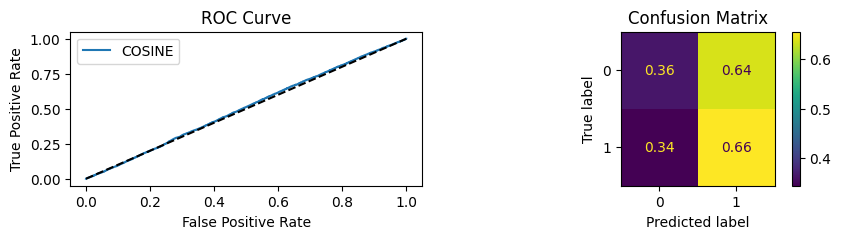

In [87]:
train_stats = evaluate_link_pred(link_predictor, compound_embs, disease_embs, edge_index_train_predict)

Youdens  index: 0.5387 Sensitivity: 0.1886 Specificity: 0.8455


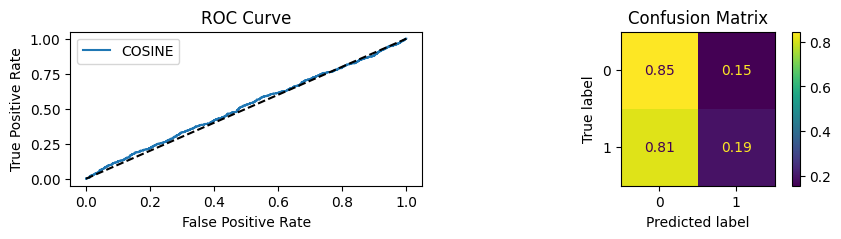

In [88]:
test_stats = evaluate_link_pred(link_predictor, compound_embs, disease_embs, edge_index_test_predict)

Youdens  index: 0.5168 Sensitivity: 0.5657 Specificity: 0.4784


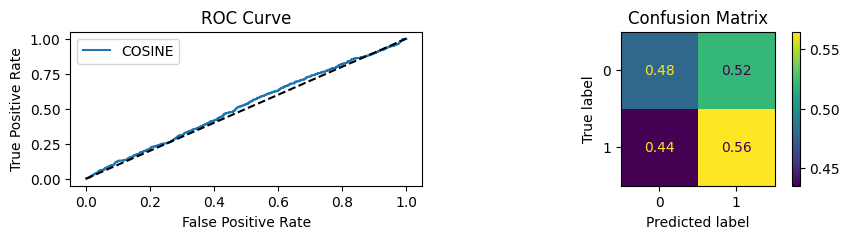

In [89]:
val_stats = evaluate_link_pred(link_predictor, compound_embs, disease_embs, edge_index_val_predict)

In [92]:
with open("../data/transe_stats.pkl", "wb") as pickle_export:
    pickle.dump(
        {"train": train_stats, "test": test_stats, "val": val_stats}, pickle_export
    )

In [93]:
with open("../data/transe_stats.pkl", "rb") as pickle_export:
    print(pickle.load(pickle_export))

{'train': {'FPR': [0.0, 0.0, 0.0, 0.0001034340091021928, 0.0001034340091021928, 0.0002068680182043856, 0.0002068680182043856, 0.0004137360364087712, 0.0004137360364087712, 0.000517170045510964, 0.000517170045510964, 0.001034340091021928, 0.001034340091021928, 0.0011377741001241208, 0.0011377741001241208, 0.0012412081092263137, 0.0012412081092263137, 0.0013446421183285063, 0.0013446421183285063, 0.0016549441456350847, 0.0016549441456350847, 0.0017583781547372776, 0.0017583781547372776, 0.002172114191146049, 0.002172114191146049, 0.0023789822093504345, 0.0023789822093504345, 0.0024824162184526274, 0.0024824162184526274, 0.00258585022755482, 0.00258585022755482, 0.0026892842366570127, 0.0026892842366570127, 0.0028961522548613984, 0.0028961522548613984, 0.0029995862639635913, 0.0029995862639635913, 0.0033098882912701694, 0.0033098882912701694, 0.003620190318576748, 0.003620190318576748, 0.003723624327678941, 0.003723624327678941, 0.003930492345883326, 0.003930492345883326, 0.00403392635498